In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

class DNN(keras.Sequential):
  def __init__(self, layer, units, activation, input_shape, dropout_rate, optimizer, loss):
    super().__init__()
    self.add(layers.Dense(units=units,activation=activation,input_shape=input_shape))
    #self.add(layers.Dropout(dropout_rate))
    #self.add(layers.BatchNormalization())
    for i in range(1,layer):
      self.add(layers.Dense(units=units,activation=activation))
      #self.add(layers.Dropout(dropout_rate))
      #self.add(layers.BatchNormalization())
    self.add(layers.Dense(units=1))
    self.compile(optimizer=optimizer,loss=loss)

def month_day(month):
  if month == 2:
    return 28
  elif month < 8:
    return 30+month%2
  else:
    return 31-month%2
def day_count(month):
  sum = 0
  for i in range(1,month):
    sum += month_day(i)
  return sum

def load_data_set(data):
  col_name = list(data.columns)
  col_name.pop(0)
  _X=[]
  _y=[]
  x_values=[]
  y_values=[]
  for i in range(0,len(col_name)):
    date = col_name[i]
    y_values = list(data[date])
    x_values = date.split('-')
    x_values = [int(x) for x in x_values]
    for j in range(0,24):
      sum=0
      if y_values[j] == 0 :
        continue
      if y_values[j] > 28000:
        print(x_values)
      sum += (x_values[0] - 2020)*8760 + 24 + day_count(x_values[1])*24 + (x_values[2]-1)*24 + j
      _X.append(sum)
      _y.append(y_values[j])
  return _X,_y

def group_split(X,y,train_size):
  X_train = []
  y_train = []
  X_val = []
  y_val = []
  for i in range(0,1000):
    random = np.random.uniform(0,1)
    if random < train_size:
      X_train.append(X[i])
      y_train.append(y[i])
    else:
      X_val.append(X[i])
      y_val.append(y[i])
  return X_train, y_train, X_val, y_val 

def load_temp_set(data):
  col_name = list(data.columns)
  date = col_name[0]
  temp = col_name[1]
  humid = col_name[2]
  date_set = list(data[date])
  temp_set = list(data[temp])
  humid_set = list(data[humid])
  date_sum = []
  for i in date_set:
    sum = 0
    a = i.split(' ')
    date = a[0].split('-')
    date = [int(x) for x in date]
    sum += (date[0] - 2020)*8760 + 24 + day_count(date[1])*24 + (date[2]-1)*24
    hour = a[1].split(':')
    hour = [int(x) for x in hour]
    sum += hour[0]
    date_sum.append(sum)
  return date_sum,temp_set,humid_set

def combine_set(x,y,date,temp,humid):
  _X = {0:'0'}
  _y = {0:'0'}
  for i in range(len(x)):
    p = x[i]
    _X[p] = [p]
    _y[p] = y[i]
  for i in range(len(date)):
    p = date[i]
    if p in _X:
      _X[p].append(temp[i])
      _X[p].append(humid[i])
  return _X,_y

def filtering_set(x,y):
  _X=[]
  _y=[]
  for i in x:
    if i==0 or len(x[i])==1:
      continue
    _X.append(x[i])
    _y.append(y[i])
  return _X,_y

#평균 전력 및 기상 정보 데이터 로드
load_data = pd.read_csv('average_power.csv')
load_temp = pd.read_csv('TempHumid.csv',encoding='cp949')


[0, 64, 279, 280, 281, 282, 283, 386, 387, 452, 472]


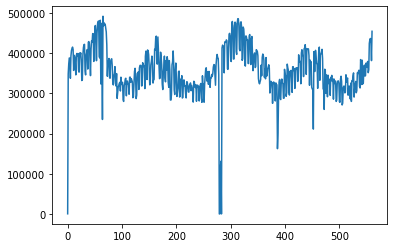

In [2]:
#load data 튀는 값 제거
load_sum_list = []
strange_data_list =[]
for i in range(load_data.shape[1]):
    loadSum = load_data.iloc[:,i].sum()
    if loadSum<270000:
        strange_data_list.append(i)
    load_sum_list.append(loadSum)
    
plt.plot(load_sum_list)
print(strange_data_list)

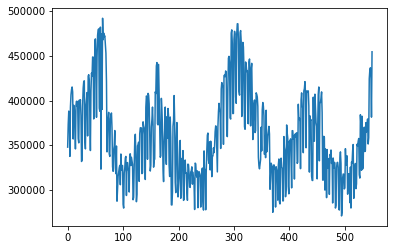

In [3]:
load_data = load_data.drop(load_data.columns[strange_data_list],axis = 1)

load_sum_list1 = []
strange_data_list1 =[]
for i in range(load_data.shape[1]):
    loadSum = load_data.iloc[:,i].sum()
    load_sum_list1.append(loadSum)
    
plt.plot(load_sum_list1)

In [9]:
layer = 9
units = 128
activation = 'relu'
train_size = 0.75
input_shape= [3]
dropout_rate = 0.5
optimizer = 'adam'
loss = 'mae'

batch_size = 1
epochs = 100

data_X, data_y = load_data_set(load_data)

date_set,temp_set,humid_set = load_temp_set(load_temp)
print(date_set[0])
raw_X,raw_y = combine_set(data_X,data_y,date_set,temp_set,humid_set)
print(len(raw_X))
X,y = filtering_set(raw_X,raw_y)
print(len(X))
print(X)
X_train, y_train, X_val, y_val = group_split(X, y, train_size)

model = DNN(layer,units,activation,input_shape,dropout_rate,optimizer,loss)
#print(model)
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


3648
13162
13135
[[3696, 19.9, 85.0], [3697, 19.8, 83.0], [3698, 20.2, 79.0], [3699, 19.9, 84.0], [3700, 18.8, 93.0], [3701, 18.3, 96.0], [3702, 18.7, 96.0], [3703, 19.4, 95.0], [3704, 20.2, 92.0], [3705, 20.6, 91.0], [3706, 21.6, 86.0], [3707, 22.6, 86.0], [3708, 24.6, 80.0], [3709, 24.8, 75.0], [3710, 25.6, 74.0], [3711, 26.7, 66.0], [3712, 27.9, 65.0], [3713, 27.4, 60.0], [3714, 25.4, 73.0], [3715, 24.2, 80.0], [3716, 24.0, 77.0], [3717, 23.8, 81.0], [3718, 23.2, 88.0], [3719, 22.5, 94.0], [3720, 21.9, 96.0], [3721, 21.8, 96.0], [3722, 21.5, 95.0], [3723, 21.3, 94.0], [3724, 20.5, 96.0], [3725, 20.3, 96.0], [3726, 20.5, 96.0], [3727, 21.3, 91.0], [3728, 22.0, 84.0], [3729, 23.4, 76.0], [3730, 24.6, 70.0], [3731, 27.3, 64.0], [3732, 28.0, 59.0], [3733, 29.0, 56.0], [3734, 30.4, 49.0], [3735, 31.0, 48.0], [3736, 31.0, 45.0], [3737, 30.6, 41.0], [3738, 29.1, 47.0], [3739, 27.1, 55.0], [3740, 25.6, 62.0], [3741, 24.2, 69.0], [3742, 23.5, 78.0], [3743, 22.8, 83.0], [3744, 21.9, 91.0], [3

In [12]:
X_train

[[3, 19.9, 84.0],
 [4, 18.8, 93.0],
 [5, 18.3, 96.0],
 [6, 18.7, 96.0],
 [7, 19.4, 95.0],
 [8, 20.2, 92.0],
 [9, 20.6, 91.0],
 [10, 21.6, 86.0],
 [11, 22.6, 86.0],
 [12, 24.6, 80.0],
 [14, 25.6, 74.0],
 [17, 27.4, 60.0],
 [18, 25.4, 73.0],
 [23, 22.5, 94.0],
 [0, 21.9, 96.0],
 [1, 21.8, 96.0],
 [2, 21.5, 95.0],
 [3, 21.3, 94.0],
 [4, 20.5, 96.0],
 [5, 20.3, 96.0],
 [6, 20.5, 96.0],
 [7, 21.3, 91.0],
 [8, 22.0, 84.0],
 [10, 24.6, 70.0],
 [11, 27.3, 64.0],
 [12, 28.0, 59.0],
 [15, 31.0, 48.0],
 [16, 31.0, 45.0],
 [17, 30.6, 41.0],
 [18, 29.1, 47.0],
 [19, 27.1, 55.0],
 [20, 25.6, 62.0],
 [21, 24.2, 69.0],
 [23, 22.8, 83.0],
 [0, 21.9, 91.0],
 [1, 21.6, 94.0],
 [2, 21.3, 95.0],
 [3, 20.9, 96.0],
 [4, 20.5, 97.0],
 [5, 20.6, 98.0],
 [7, 20.8, 97.0],
 [8, 22.3, 94.0],
 [9, 23.9, 85.0],
 [10, 25.4, 81.0],
 [11, 27.2, 70.0],
 [12, 28.7, 60.0],
 [13, 29.4, 56.0],
 [14, 31.0, 53.0],
 [15, 32.1, 47.0],
 [16, 31.2, 46.0],
 [17, 31.3, 55.0],
 [19, 27.1, 72.0],
 [20, 25.0, 80.0],
 [21, 23.8, 86.0],

In [13]:
for i in X:
    i[0] = i[0]%24

[14085.7,
 13739.1,
 13587.2,
 12649.1,
 12624.8,
 12717.0,
 12762.5,
 13087.6,
 15110.9,
 16245.5,
 16856.4,
 17057.0,
 16924.9,
 18004.2,
 17831.8,
 18365.7,
 18133.1,
 17975.8,
 17670.0,
 16422.8,
 16379.1,
 15225.0,
 15172.0,
 14904.8,
 14503.8,
 14325.3,
 13623.5,
 13355.2,
 13654.1,
 13175.2,
 13047.1,
 13424.4,
 15651.7,
 17017.1,
 17535.8,
 17566.8,
 18089.8,
 18822.1,
 19018.3,
 19102.4,
 19483.5,
 19096.0,
 18189.8,
 17057.6,
 16823.1,
 15652.9,
 15356.0,
 14705.5,
 14675.8,
 14177.7,
 13644.5,
 13463.2,
 13173.9,
 12749.7,
 12620.1,
 13576.8,
 15927.9,
 17000.8,
 18017.8,
 18306.1,
 18322.6,
 19192.1,
 19487.6,
 19697.2,
 18938.2,
 18943.7,
 17816.4,
 16391.6,
 16085.2,
 15366.6,
 15172.2,
 14427.5,
 13935.8,
 13615.0,
 13329.0,
 12815.3,
 12910.2,
 12554.7,
 12466.8,
 12772.8,
 13334.3,
 13693.6,
 13418.9,
 13891.7,
 14453.4,
 14714.0,
 15301.4,
 15350.1,
 15534.7,
 15240.4,
 14925.4,
 15069.6,
 14845.8,
 14681.7,
 14567.5,
 14283.7,
 14025.4,
 13491.1,
 13358.9,
 12928.0,


In [14]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('load_prediction_with_hour_information.tf', save_best_only = True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=25,
    epochs=100,
    callbacks = [checkpoint_cb],
    verbose=1, # suppress output since we'll plot the curves
)

Epoch 1/100
30/30 [==============================] - 3s 73ms/step - loss: 12651.4395 - val_loss: 3207.1865
Epoch 2/100
30/30 [==============================] - 2s 61ms/step - loss: 3304.8699 - val_loss: 2590.1296
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 2537.7605 - val_loss: 2094.4336
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 2146.2266 - val_loss: 1921.2245
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 1911.9607 - val_loss: 1963.8130
Epoch 6/100
30/30 [==============================] - 2s 65ms/step - loss: 1791.7900 - val_loss: 1855.6772
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 1584.6510 - val_loss: 1552.4166
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 1514.9774 - val_loss: 1579.4128
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 1546.2333 - val_loss: 1607.2107
Epoch 10/100
30/30 [============================

30/30 [==============================] - 0s 3ms/step - loss: 1435.0726 - val_loss: 1524.7203
Epoch 56/100
30/30 [==============================] - 0s 3ms/step - loss: 1434.5854 - val_loss: 1506.5253
Epoch 57/100
30/30 [==============================] - 2s 61ms/step - loss: 1399.6401 - val_loss: 1438.4630
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 1407.0028 - val_loss: 1455.2491
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 1404.5721 - val_loss: 1615.0990
Epoch 60/100
30/30 [==============================] - 0s 3ms/step - loss: 1436.6312 - val_loss: 1459.3248
Epoch 61/100
30/30 [==============================] - 0s 3ms/step - loss: 1406.0962 - val_loss: 1546.4252
Epoch 62/100
30/30 [==============================] - 0s 3ms/step - loss: 1528.6349 - val_loss: 1865.1426
Epoch 63/100
30/30 [==============================] - 0s 3ms/step - loss: 1484.9633 - val_loss: 1440.0349
Epoch 64/100
30/30 [==============================] - 0s 3

Minimum Validation Loss: 1363.2963


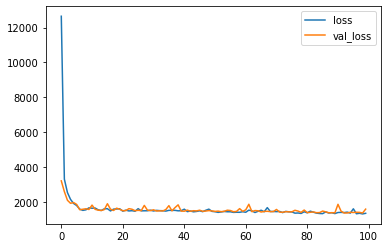

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [ ]:
model.save('model1')

24/24 [==============================] - 0s 1ms/step


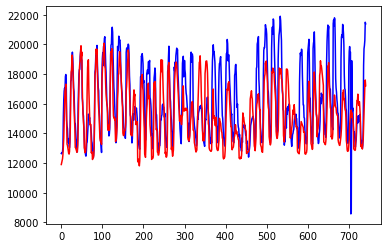

In [19]:
new_model = keras.models.load_model('load_prediction_with_hour_information.tf')

predict = model.predict(X_train)
plt.plot(y_train,'b')
plt.plot(predict,'r')


2/2 [==============================] - 0s 2ms/step


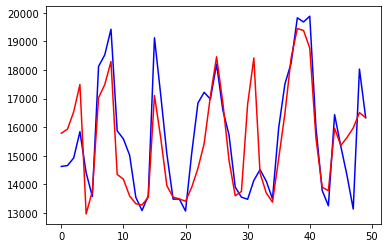

In [23]:
predict = new_model.predict(X_val[50:100])
plt.plot(y_val[50:100],'b')
plt.plot(predict,'r')